In [8]:
import os
import time
from collections import defaultdict 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import precision_score, recall_score, accuracy_score, make_scorer, f1_score
from scipy.stats import ttest_ind
from imblearn.pipeline import Pipeline

# Analysis on test and train set

In [5]:
#Reading test and training set
train_file = './UNSW_NB15_training-set.csv'
test_file = './UNSW_NB15_test-set.csv'

In [6]:
train_df = pd.read_csv(train_file, index_col = 0) # Reading training set from file
train_header_names = train_df.keys() #Get the names of columns
train_df.describe()

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
count,175341.000000,175341.000000,175341.000000,1.753410e+05,1.753410e+05,1.753410e+05,175341.000000,175341.000000,1.753410e+05,1.753410e+05,...,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000
mean,1.359389,20.298664,18.969591,8.844844e+03,1.492892e+04,9.540619e+04,179.546997,79.609567,7.345403e+07,6.712056e+05,...,5.383538,4.206255,8.729881,0.014948,0.014948,0.133066,6.955789,9.100758,0.015752,0.680622
std,6.480249,136.887597,110.258271,1.747656e+05,1.436542e+05,1.654010e+05,102.940011,110.506863,1.883574e+08,2.421312e+06,...,8.047104,5.783585,10.956186,0.126048,0.126048,0.701208,8.321493,10.756952,0.124516,0.466237
min,0.000000,1.000000,0.000000,2.800000e+01,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,0.000008,2.000000,0.000000,1.140000e+02,0.000000e+00,3.278614e+01,62.000000,0.000000,1.305334e+04,0.000000e+00,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000
50%,0.001582,2.000000,2.000000,4.300000e+02,1.640000e+02,3.225807e+03,254.000000,29.000000,8.796748e+05,1.447023e+03,...,1.000000,1.000000,3.000000,0.000000,0.000000,0.000000,3.000000,4.000000,0.000000,1.000000
75%,0.668069,12.000000,10.000000,1.418000e+03,1.102000e+03,1.250000e+05,254.000000,252.000000,8.888889e+07,2.784487e+04,...,5.000000,3.000000,12.000000,0.000000,0.000000,0.000000,9.000000,12.000000,0.000000,1.000000
max,59.999989,9616.000000,10974.000000,1.296523e+07,1.465555e+07,1.000000e+06,255.000000,254.000000,5.988000e+09,2.242273e+07,...,51.000000,46.000000,65.000000,4.000000,4.000000,30.000000,60.000000,62.000000,1.000000,1.000000


In [7]:
test_df = pd.read_csv(test_file, index_col = 0) # Reading test set from file
test_header_names = test_df.keys() #Get the names of columns
test_df.describe()

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
count,82332.000000,82332.000000,82332.000000,8.233200e+04,8.233200e+04,8.233200e+04,82332.000000,82332.000000,8.233200e+04,8.233200e+04,...,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000
mean,1.006756,18.666472,17.545936,7.993908e+03,1.323379e+04,8.241089e+04,180.967667,95.713003,6.454902e+07,6.305470e+05,...,4.928898,3.663011,7.456360,0.008284,0.008381,0.129743,6.468360,9.164262,0.011126,0.550600
std,4.710444,133.916353,115.574086,1.716423e+05,1.514715e+05,1.486204e+05,101.513358,116.667722,1.798618e+08,2.393001e+06,...,8.389545,5.915386,11.415191,0.091171,0.092485,0.638683,8.543927,11.121413,0.104891,0.497436
min,0.000000,1.000000,0.000000,2.400000e+01,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,0.000008,2.000000,0.000000,1.140000e+02,0.000000e+00,2.860611e+01,62.000000,0.000000,1.120247e+04,0.000000e+00,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000
50%,0.014138,6.000000,2.000000,5.340000e+02,1.780000e+02,2.650177e+03,254.000000,29.000000,5.770032e+05,2.112951e+03,...,1.000000,1.000000,3.000000,0.000000,0.000000,0.000000,3.000000,5.000000,0.000000,1.000000
75%,0.719360,12.000000,10.000000,1.280000e+03,9.560000e+02,1.111111e+05,254.000000,252.000000,6.514286e+07,1.585808e+04,...,4.000000,3.000000,6.000000,0.000000,0.000000,0.000000,7.000000,11.000000,0.000000,1.000000
max,59.999989,10646.000000,11018.000000,1.435577e+07,1.465753e+07,1.000000e+06,255.000000,253.000000,5.268000e+09,2.082111e+07,...,59.000000,38.000000,63.000000,2.000000,2.000000,16.000000,60.000000,62.000000,1.000000,1.000000


In [5]:
# TRAINING SET: Differentiating between nominal, binary, and numeric features

train_col_names = np.array(train_header_names)

train_nominal_idx = [1, 2, 3, 42]
train_binary_idx = [41, 43] 
train_numeric_idx = list(set(range(43)).difference(train_nominal_idx).difference(train_binary_idx))

train_nominal_cols = train_col_names[train_nominal_idx].tolist()
train_binary_cols = train_col_names[train_binary_idx].tolist()
train_numeric_cols = train_col_names[train_numeric_idx].tolist()

In [6]:
# TEST SET: Differentiating between nominal, binary, and numeric features

test_col_names = np.array(test_header_names)

test_nominal_idx = [1, 2, 3, 42]
test_binary_idx = [41, 43] 
test_numeric_idx = list(set(range(43)).difference(test_nominal_idx).difference(test_binary_idx))

test_nominal_cols = test_col_names[test_nominal_idx].tolist()
test_binary_cols = test_col_names[test_binary_idx].tolist()
test_numeric_cols = test_col_names[test_numeric_idx].tolist()

## Data Distribution 

### Training Set

In [7]:
#Data distribution of training set 

train_label = train_df['label'].value_counts()
train_attack_cats = train_df['attack_cat'].value_counts()

print(train_label)
print('\n')
print(train_attack_cats)

1    119341
0     56000
Name: label, dtype: int64


Normal            56000
Generic           40000
Exploits          33393
Fuzzers           18184
DoS               12264
Reconnaissance    10491
Analysis           2000
Backdoor           1746
Shellcode          1133
Worms               130
Name: attack_cat, dtype: int64


<AxesSubplot:>

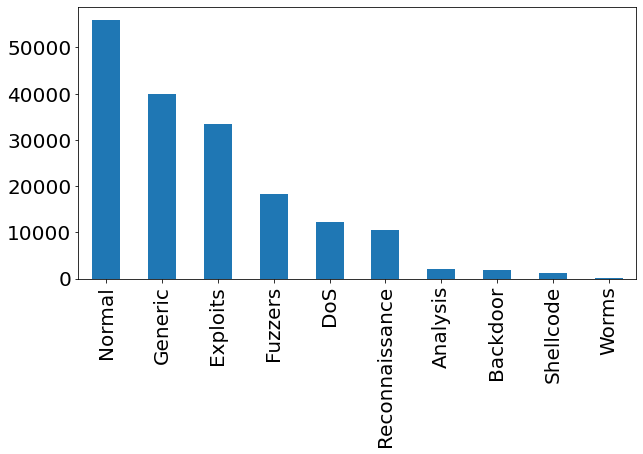

In [8]:
#Plotting attack categories istances of training set
train_attack_cats.plot(kind='bar', figsize=(10,5), fontsize=20)

<AxesSubplot:>

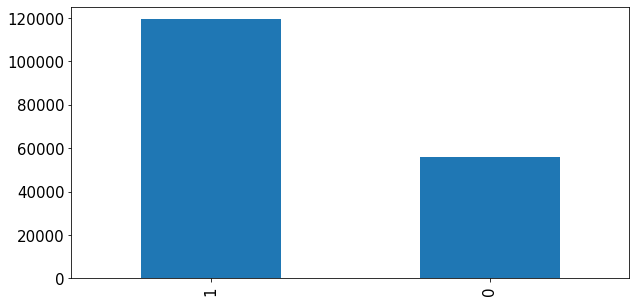

In [9]:
#Plotting attack labels (0: normal, 1: attack) of training set
train_label.plot(kind='bar', figsize=(10,5), fontsize=15)

### Test set

In [10]:
#Data distribution of test set 

test_label = test_df['label'].value_counts()
test_attack_cats = test_df['attack_cat'].value_counts()

print(test_label)
print('\n')
print(test_attack_cats)

1    45332
0    37000
Name: label, dtype: int64


Normal            37000
Generic           18871
Exploits          11132
Fuzzers            6062
DoS                4089
Reconnaissance     3496
Analysis            677
Backdoor            583
Shellcode           378
Worms                44
Name: attack_cat, dtype: int64


<AxesSubplot:>

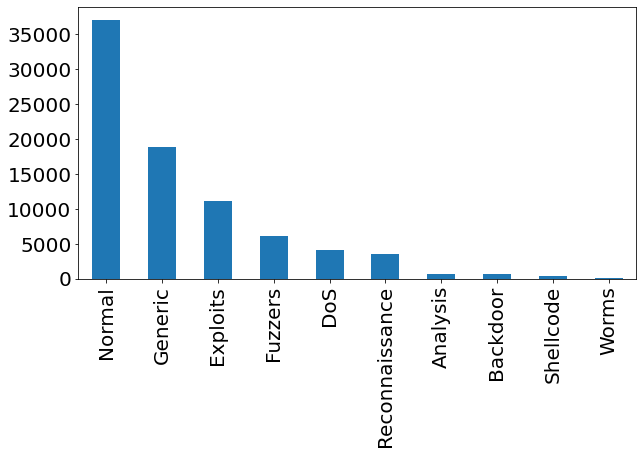

In [11]:
#Plotting attack categories istances of test set
test_attack_cats.plot(kind='bar', figsize=(10,5), fontsize=20)

<AxesSubplot:>

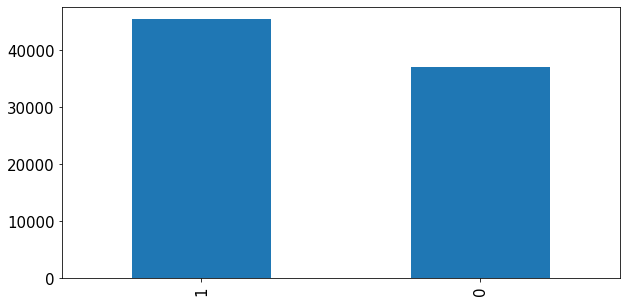

In [12]:
#Plotting attack labels (0: normal, 1: attack) of test set
test_label.plot(kind='bar', figsize=(10,5), fontsize=15)

# Data Cleaning

In [13]:
# Binary features: by definition, all of these features should have a min of 0.0 and a max of 1.0

train_df[train_binary_cols].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
is_sm_ips_ports,175341.0,0.015752,0.124516,0.0,0.0,0.0,0.0,1.0
label,175341.0,0.680622,0.466237,0.0,0.0,1.0,1.0,1.0


In [14]:
#Check if some columns has always the same value (to see if some features can be removed)

# Time complexity: O(n)
def unique_cols(train_df):
    a = train_df.to_numpy()
    return (a[0] == a).all(0)

unique_cols(train_df)

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False])

# Data Preparation

In [15]:
#Removing class label and attack_cat feature from training set 

train_y = train_df['label']
train_x_raw = train_df.drop(['attack_cat','label'], axis=1)
train_nominal_cols.remove('attack_cat')

In [16]:
#Remove nan records
train_x_raw.dropna(axis=0, inplace=True)

In [17]:
# Transform nominal features in binary features
train_x = pd.get_dummies(train_x_raw, columns=train_nominal_cols, drop_first=True) 
dummy_variables = list(set(train_x)-set(train_x_raw))

In [18]:
train_x.describe()

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,service_ssh,service_ssl,state_ECO,state_FIN,state_INT,state_PAR,state_REQ,state_RST,state_URN,state_no
count,175341.000000,175341.000000,175341.000000,1.753410e+05,1.753410e+05,1.753410e+05,175341.000000,175341.000000,1.753410e+05,1.753410e+05,...,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000
mean,1.359389,20.298664,18.969591,8.844844e+03,1.492892e+04,9.540619e+04,179.546997,79.609567,7.345403e+07,6.712056e+05,...,0.007426,0.000319,0.000068,0.443849,0.469229,0.000006,0.011355,0.000473,0.000006,0.000006
std,6.480249,136.887597,110.258271,1.747656e+05,1.436542e+05,1.654010e+05,102.940011,110.506863,1.883574e+08,2.421312e+06,...,0.085851,0.017868,0.008272,0.496839,0.499054,0.002388,0.105954,0.021752,0.002388,0.002388
min,0.000000,1.000000,0.000000,2.800000e+01,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000008,2.000000,0.000000,1.140000e+02,0.000000e+00,3.278614e+01,62.000000,0.000000,1.305334e+04,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.001582,2.000000,2.000000,4.300000e+02,1.640000e+02,3.225807e+03,254.000000,29.000000,8.796748e+05,1.447023e+03,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.668069,12.000000,10.000000,1.418000e+03,1.102000e+03,1.250000e+05,254.000000,252.000000,8.888889e+07,2.784487e+04,...,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,59.999989,9616.000000,10974.000000,1.296523e+07,1.465555e+07,1.000000e+06,255.000000,254.000000,5.988000e+09,2.242273e+07,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [19]:
#Removing class label and attack_cat feature from test set 

test_y = test_df['label']
test_x_raw = test_df.drop(['attack_cat','label'], axis=1)
test_nominal_cols.remove('attack_cat')

test_x = pd.get_dummies(test_x_raw, columns=test_nominal_cols, drop_first=True)
dummy_variables = list(set(test_x)-set(test_x_raw))
test_x.describe()

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,service_smtp,service_snmp,service_ssh,service_ssl,state_CLO,state_CON,state_FIN,state_INT,state_REQ,state_RST
count,82332.000000,82332.000000,82332.000000,8.233200e+04,8.233200e+04,8.233200e+04,82332.000000,82332.000000,8.233200e+04,8.233200e+04,...,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000
mean,1.006756,18.666472,17.545936,7.993908e+03,1.323379e+04,8.241089e+04,180.967667,95.713003,6.454902e+07,6.305470e+05,...,0.022482,0.000352,0.002478,0.000364,0.000012,0.084803,0.477809,0.414942,0.022373,0.000012
std,4.710444,133.916353,115.574086,1.716423e+05,1.514715e+05,1.486204e+05,101.513358,116.667722,1.798618e+08,2.393001e+06,...,0.148246,0.018765,0.049716,0.019085,0.003485,0.278590,0.499510,0.492715,0.147894,0.003485
min,0.000000,1.000000,0.000000,2.400000e+01,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000008,2.000000,0.000000,1.140000e+02,0.000000e+00,2.860611e+01,62.000000,0.000000,1.120247e+04,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.014138,6.000000,2.000000,5.340000e+02,1.780000e+02,2.650177e+03,254.000000,29.000000,5.770032e+05,2.112951e+03,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.719360,12.000000,10.000000,1.280000e+03,9.560000e+02,1.111111e+05,254.000000,252.000000,6.514286e+07,1.585808e+04,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
max,59.999989,10646.000000,11018.000000,1.435577e+07,1.465753e+07,1.000000e+06,255.000000,253.000000,5.268000e+09,2.082111e+07,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [20]:
#Adding missing binary features at 0 in test set
for column in train_x.columns:
    if column not in test_x.columns:
        test_x[column] = 0

#Removing features which are in test set but not in training set
for column in test_x.columns:
    if column not in train_x.columns:
        test_x.drop([column], axis=1, inplace=True)

In [21]:
test_x.describe()

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,state_FIN,state_INT,state_REQ,state_RST,proto_icmp,proto_rtp,state_ECO,state_PAR,state_URN,state_no
count,82332.000000,82332.000000,82332.000000,8.233200e+04,8.233200e+04,8.233200e+04,82332.000000,82332.000000,8.233200e+04,8.233200e+04,...,82332.000000,82332.000000,82332.000000,82332.000000,82332.0,82332.0,82332.0,82332.0,82332.0,82332.0
mean,1.006756,18.666472,17.545936,7.993908e+03,1.323379e+04,8.241089e+04,180.967667,95.713003,6.454902e+07,6.305470e+05,...,0.477809,0.414942,0.022373,0.000012,0.0,0.0,0.0,0.0,0.0,0.0
std,4.710444,133.916353,115.574086,1.716423e+05,1.514715e+05,1.486204e+05,101.513358,116.667722,1.798618e+08,2.393001e+06,...,0.499510,0.492715,0.147894,0.003485,0.0,0.0,0.0,0.0,0.0,0.0
min,0.000000,1.000000,0.000000,2.400000e+01,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.000008,2.000000,0.000000,1.140000e+02,0.000000e+00,2.860611e+01,62.000000,0.000000,1.120247e+04,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.014138,6.000000,2.000000,5.340000e+02,1.780000e+02,2.650177e+03,254.000000,29.000000,5.770032e+05,2.112951e+03,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.719360,12.000000,10.000000,1.280000e+03,9.560000e+02,1.111111e+05,254.000000,252.000000,6.514286e+07,1.585808e+04,...,1.000000,1.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
max,59.999989,10646.000000,11018.000000,1.435577e+07,1.465753e+07,1.000000e+06,255.000000,253.000000,5.268000e+09,2.082111e+07,...,1.000000,1.000000,1.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
#Check if test set and training set have the same number of features
print(len(train_x.keys()))

191


In [23]:
#Normalization of numeric features

#FIT
standard_scaler = StandardScaler().fit(train_x[train_numeric_cols])

#TRANSFORM
train_x[train_numeric_cols] = standard_scaler.transform(train_x[train_numeric_cols])
test_x[test_numeric_cols] = standard_scaler.transform(test_df[test_numeric_cols])

In [24]:
#Sorting test set and training set by features in alphabetical order
train_x = train_x.sort_index(axis=1)
test_x = test_x.sort_index(axis=1)

In [25]:
test_x.describe()

,ackdat,ct_dst_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,ct_flw_http_mthd,ct_ftp_cmd,ct_src_dport_ltm,ct_src_ltm,ct_srv_dst,ct_srv_src,...,state_REQ,state_RST,state_URN,state_no,stcpb,sttl,swin,synack,tcprtt,trans_depth
count,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,...,82332.000000,82332.000000,82332.0,82332.0,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000
mean,0.155382,-0.055761,-0.093929,-0.116238,-0.004740,-0.052102,-0.056498,-0.058575,0.005904,0.022436,...,0.022373,0.000012,0.0,0.0,0.085143,0.013801,0.135446,0.189759,0.183097,-0.015066
std,1.360125,1.045410,1.022792,1.041898,0.910835,0.733731,1.042558,1.026733,1.033884,1.036059,...,0.147894,0.003485,0.0,0.0,1.026268,0.986144,1.002806,1.632582,1.462083,0.698823
min,-0.503014,-0.645013,-0.554373,-0.705529,-0.189768,-0.118590,-0.544736,-0.715714,-0.753074,-0.775991,...,0.000000,0.000000,0.0,0.0,-0.715177,-1.744196,-0.915407,-0.484346,-0.521660,-0.136415
25%,-0.503014,-0.645013,-0.554373,-0.705529,-0.189768,-0.118590,-0.544736,-0.715714,-0.660111,-0.682570,...,0.000000,0.000000,0.0,0.0,-0.715177,-1.141901,-0.915407,-0.484346,-0.521660,-0.136415
50%,-0.501039,-0.520827,-0.554373,-0.522983,-0.189768,-0.118590,-0.544736,-0.475371,-0.381220,-0.402309,...,0.000000,0.000000,0.0,0.0,-0.694598,0.723268,1.092456,-0.474185,-0.514716,-0.136415
75%,0.702140,-0.024084,-0.208566,-0.249164,-0.189768,-0.118590,-0.171930,0.005313,0.176560,0.158213,...,0.000000,0.000000,0.0,0.0,0.886958,0.723268,1.092456,0.727541,0.808344,-0.136415
max,71.801352,6.557761,5.843061,4.953391,22.628076,15.748420,6.662846,6.374381,4.917694,5.016074,...,1.000000,1.000000,0.0,0.0,2.453919,0.732982,1.092456,73.866191,47.635677,168.480595


In [26]:
train_x.describe()

,ackdat,ct_dst_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,ct_flw_http_mthd,ct_ftp_cmd,ct_src_dport_ltm,ct_src_ltm,ct_srv_dst,ct_srv_src,...,state_REQ,state_RST,state_URN,state_no,stcpb,sttl,swin,synack,tcprtt,trans_depth
count,1.753410e+05,1.753410e+05,1.753410e+05,1.753410e+05,1.753410e+05,1.753410e+05,1.753410e+05,1.753410e+05,1.753410e+05,1.753410e+05,...,175341.000000,175341.000000,175341.000000,175341.000000,1.753410e+05,1.753410e+05,1.753410e+05,1.753410e+05,1.753410e+05,1.753410e+05
mean,6.743107e-17,1.115206e-16,3.630904e-17,5.187005e-17,-5.187005e-18,-6.483757e-18,9.336610e-17,3.630904e-17,-8.299209e-17,4.408955e-17,...,0.011355,0.000473,0.000006,0.000006,8.428884e-17,-1.607972e-16,2.334152e-17,-1.115206e-16,7.910183e-17,-2.139640e-17
std,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,...,0.105954,0.021752,0.002388,0.002388,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00
min,-5.030137e-01,-6.450129e-01,-5.543732e-01,-7.055286e-01,-1.897681e-01,-1.185902e-01,-5.447364e-01,-7.157137e-01,-7.530740e-01,-7.759906e-01,...,0.000000,0.000000,0.000000,0.000000,-7.151765e-01,-1.744196e+00,-9.154073e-01,-4.843460e-01,-5.216596e-01,-1.364151e-01
25%,-5.030137e-01,-6.450129e-01,-5.543732e-01,-7.055286e-01,-1.897681e-01,-1.185902e-01,-5.447364e-01,-5.955426e-01,-6.601106e-01,-6.825702e-01,...,0.000000,0.000000,0.000000,0.000000,-7.151765e-01,-1.141901e+00,-9.154073e-01,-4.843460e-01,-5.216596e-01,-1.364151e-01
50%,-5.030137e-01,-5.208272e-01,-5.543732e-01,-5.229828e-01,-1.897681e-01,-1.185902e-01,-5.447364e-01,-4.753715e-01,-4.741838e-01,-4.023091e-01,...,0.000000,0.000000,0.000000,0.000000,-7.151765e-01,7.232680e-01,-9.154073e-01,-4.843460e-01,-5.216596e-01,-1.364151e-01
75%,4.574803e-01,1.001016e-01,-2.085659e-01,2.984733e-01,-1.897681e-01,-1.185902e-01,-4.766180e-02,2.456551e-01,2.695234e-01,2.516337e-01,...,0.000000,0.000000,0.000000,0.000000,6.990545e-01,7.232680e-01,1.092456e+00,5.178726e-02,3.035188e-01,-1.364151e-01
max,3.704389e+01,5.564275e+00,7.226290e+00,5.135937e+00,4.259369e+01,3.161543e+01,5.668697e+00,6.374381e+00,4.917694e+00,5.016074e+00,...,1.000000,1.000000,1.000000,1.000000,2.453926e+00,7.329824e-01,1.092456e+00,4.791124e+01,3.122093e+01,2.212539e+02


In [27]:
#Check if training set and test set have features in the same order
train_x.keys() == test_x.keys()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

# Logistic Regression

Training time: 45.27 sec
0.8090414419666715
              precision    recall  f1-score   support

      normal       0.95      0.61      0.74     37000
      attack       0.75      0.97      0.85     45332

    accuracy                           0.81     82332
   macro avg       0.85      0.79      0.80     82332
weighted avg       0.84      0.81      0.80     82332



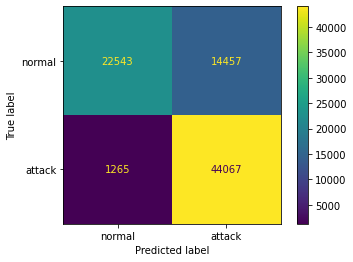

In [28]:
model_lr = LogisticRegression(max_iter=1000)

start = time.time()
model_lr.fit(train_x, train_y)
end = time.time()
print('Training time: ' + str(round(end-start, 2)) + ' sec')

y_pred = model_lr.predict(test_x)

print(accuracy_score(test_y, y_pred))

#Classification report
print(classification_report(test_y,y_pred,target_names = ['normal','attack']))

#confusion matrix
ConfusionMatrixDisplay.from_predictions(test_y, y_pred,display_labels = ['normal','attack'])
plt.show()

# Decision Tree

Training time: 3.99 sec
0.8631151921488607
              precision    recall  f1-score   support

      normal       0.93      0.75      0.83     37000
      attack       0.82      0.96      0.88     45332

    accuracy                           0.86     82332
   macro avg       0.88      0.85      0.86     82332
weighted avg       0.87      0.86      0.86     82332



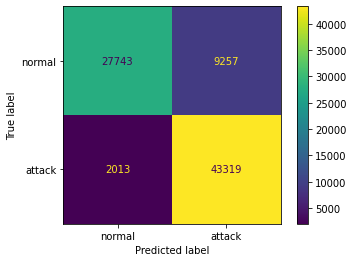

In [29]:
model_dt = DecisionTreeClassifier()

start = time.time()
model_dt.fit(train_x, train_y)
end = time.time()
print('Training time: ' + str(round(end-start, 2)) + ' sec')

y_pred = model_dt.predict(test_x)

print(accuracy_score(test_y, y_pred))

#Classification report
print(classification_report(test_y,y_pred,target_names = ['normal','attack']))

#confusion matrix
ConfusionMatrixDisplay.from_predictions(test_y, y_pred,display_labels = ['normal','attack'])
plt.show()

# Naive Bayes: Gaussian

Training time: 1.17 sec
0.5558592041976388
              precision    recall  f1-score   support

      normal       0.50      1.00      0.67     37000
      attack       1.00      0.19      0.32     45332

    accuracy                           0.56     82332
   macro avg       0.75      0.60      0.50     82332
weighted avg       0.78      0.56      0.48     82332



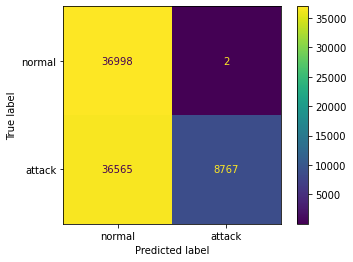

In [30]:
model_nbg = GaussianNB()

start = time.time()
model_nbg.fit(train_x, train_y)
end = time.time()
print('Training time: ' + str(round(end-start, 2)) + ' sec')


y_pred = model_nbg.predict(test_x)

print(accuracy_score(test_y, y_pred))

#Classification report
print(classification_report(test_y,y_pred,target_names = ['normal','attack']))

#confusion matrix
ConfusionMatrixDisplay.from_predictions(test_y, y_pred,display_labels = ['normal','attack'])
plt.show()

# Naive Bayes: Complement (suitable for unbalanced dataset)

### Pre-process with min max to avoid negative values

In [31]:
from sklearn.naive_bayes import ComplementNB
from sklearn.preprocessing import MinMaxScaler

model_nbc = ComplementNB()

scaler = MinMaxScaler()

#Fit only on training set, transform on both training and test
train_x_new = scaler.fit_transform(train_x)
test_x_new = scaler.transform(test_x)

Training time: 0.14 sec
0.6994607200116602
              precision    recall  f1-score   support

      normal       0.65      0.74      0.69     37000
      attack       0.76      0.67      0.71     45332

    accuracy                           0.70     82332
   macro avg       0.70      0.70      0.70     82332
weighted avg       0.71      0.70      0.70     82332



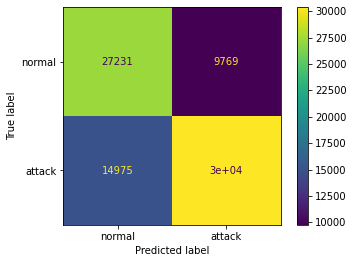

In [32]:

start = time.time()
model_nbc.fit(train_x_new, train_y)
end = time.time()
print('Training time: ' + str(round(end-start, 2)) + ' sec')


y_pred = model_nbc.predict(test_x_new)

print(accuracy_score(test_y, y_pred))

#Classification report
print(classification_report(test_y,y_pred,target_names = ['normal','attack']))

#confusion matrix
ConfusionMatrixDisplay.from_predictions(test_y, y_pred,display_labels = ['normal','attack'])
plt.show()

# Neural Network

Training time: 226.47 sec
0.8563499004032454
              precision    recall  f1-score   support

      normal       0.98      0.69      0.81     37000
      attack       0.80      0.99      0.88     45332

    accuracy                           0.86     82332
   macro avg       0.89      0.84      0.85     82332
weighted avg       0.88      0.86      0.85     82332



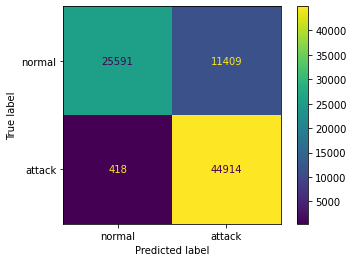

In [33]:
model_nn = MLPClassifier(solver='adam', max_iter=1000, hidden_layer_sizes = (10,5))

start = time.time()
model_nn.fit(train_x, train_y)
end = time.time()
print('Training time: ' + str(round(end-start, 2)) + ' sec')

y_pred = model_nn.predict(test_x)

print(accuracy_score(test_y, y_pred))

#Classification report
print(classification_report(test_y,y_pred,target_names = ['normal','attack']))

#confusion matrix
ConfusionMatrixDisplay.from_predictions(test_y, y_pred,display_labels = ['normal','attack'])
plt.show()

# Random Forest

Training time: 29.73 sec
0.8652528785891269
              precision    recall  f1-score   support

      normal       0.98      0.71      0.83     37000
      attack       0.81      0.99      0.89     45332

    accuracy                           0.87     82332
   macro avg       0.90      0.85      0.86     82332
weighted avg       0.89      0.87      0.86     82332



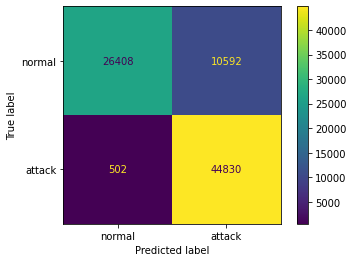

In [34]:
model_rf = RandomForestClassifier(max_depth=20, random_state=0)

start = time.time()
model_rf.fit(train_x, train_y)
end = time.time()
print('Training time: ' + str(round(end-start, 2)) + ' sec')

y_pred = model_rf.predict(test_x)

print(accuracy_score(test_y, y_pred))

#Classification report
print(classification_report(test_y,y_pred,target_names = ['normal','attack']))

#confusion matrix
ConfusionMatrixDisplay.from_predictions(test_y, y_pred,display_labels = ['normal','attack'])
plt.show()

# Rebalancing of dataset: Under-sampling

Class 0: 56000
Class 1: 119341
Proportion: 0.47 : 1


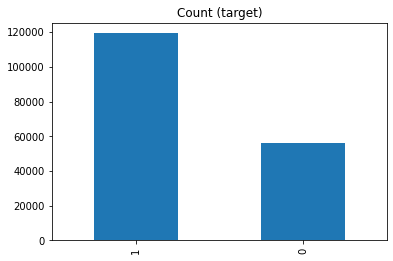

In [35]:
print('Class 0:', train_label[0])
print('Class 1:', train_label[1])
print('Proportion:', round(train_label[0] / train_label[1], 2), ': 1')

train_label.plot(kind='bar', title='Count (target)');

In [36]:
#DATA CLEANING & PRE-PROCESSING 

#Reading of test set and training set from files and preprocessing 

rb_train_x = pd.read_csv(train_file, index_col = 0) 
rb_test_x = pd.read_csv(test_file, index_col = 0) 

#---------

rb_train_x.dropna(axis=0, inplace=True)

rb_train_x = pd.get_dummies(rb_train_x, columns=train_nominal_cols, drop_first=True)
rb_test_x = pd.get_dummies(rb_test_x, columns=test_nominal_cols, drop_first=True)

#---------

#Adding missing binary features with value at 0 in test set
for column in rb_train_x.columns:
    if column not in rb_test_x.columns:
        rb_test_x[column] = 0
        
#Removing features which are in test set but not in training set
for column in rb_test_x.columns:
    if column not in rb_train_x.columns:
        rb_test_x.drop([column], axis=1, inplace=True)

#---------
        
#Normalization of numeric features
#FIT
standard_scaler = StandardScaler().fit(rb_train_x[train_numeric_cols])

#TRANSFORM
rb_train_x[train_numeric_cols] = standard_scaler.transform(rb_train_x[train_numeric_cols])
rb_test_x[test_numeric_cols] = standard_scaler.transform(rb_test_x[test_numeric_cols])

#---------

#Sorting of test set and training set
rb_train_x = rb_train_x.sort_index(axis=1)
rb_test_x = rb_test_x.sort_index(axis=1)

#Merging training set and test set to perform k-fold cross validation later
k_validation_data = pd.concat([rb_train_x, rb_test_x]) 


In [37]:
rb_train_df_class_0 = rb_train_x[rb_train_x['label'] == 0]
rb_train_df_class_1 = rb_train_x[rb_train_x['label'] == 1]

count_label_0 = train_label[0]
count_label_1 = train_label[1]

print('1: ' + str(count_label_1))
print('0: ' + str(count_label_0))

1: 119341
0: 56000


Random under-sampling:
0    56000
1    56000
Name: label, dtype: int64


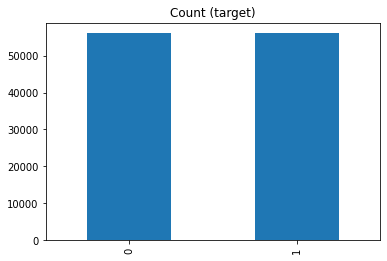

In [38]:
rb_train_y_under = rb_train_x['label']
rb_train_x_under = rb_train_x.drop(['attack_cat','label'], axis=1)

test_y_under = rb_test_x['label']
test_x_under = rb_test_x.drop(['attack_cat','label'], axis=1)

rus = RandomUnderSampler()
train_x_under, train_y_under = rus.fit_resample(rb_train_x_under, rb_train_y_under)

x_cross_under = np.r_[train_x_under, test_x_under]
y_cross_under = np.r_[train_y_under, test_y_under]

print('Random under-sampling:')
print(train_y_under.value_counts())
train_y_under.value_counts().plot(kind='bar', title='Count (target)');

In [39]:
model_rb_train_y = train_y_under
model_rb_train_x = train_x_under

model_rb_test_y = test_y_under
model_rb_test_x = test_x_under

# Logistic Regression after Rebalancing

Training time: 25.07 sec
0.8344750522275665
              precision    recall  f1-score   support

      normal       0.89      0.72      0.80     37000
      attack       0.80      0.93      0.86     45332

    accuracy                           0.83     82332
   macro avg       0.85      0.82      0.83     82332
weighted avg       0.84      0.83      0.83     82332



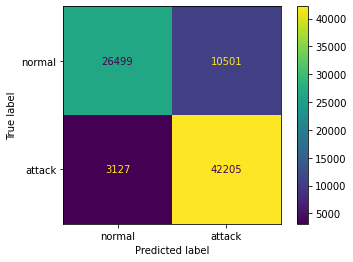

In [40]:
model_lr_u = LogisticRegression(max_iter=1000)

start = time.time()
model_lr_u.fit(model_rb_train_x, model_rb_train_y)
end = time.time()
print('Training time: ' + str(round(end-start, 2)) + ' sec')

model_rb_y_pred = model_lr_u.predict(model_rb_test_x)

print(accuracy_score(model_rb_test_y, model_rb_y_pred))

#Classification report
print(classification_report(model_rb_test_y, model_rb_y_pred, target_names = ['normal','attack']))

#confusion matrix
ConfusionMatrixDisplay.from_predictions(model_rb_test_y, model_rb_y_pred, display_labels = ['normal','attack'])
plt.show()

# Decision Tree after Rebalancing

Training time: 2.2 sec
0.8825365592965069
              precision    recall  f1-score   support

      normal       0.93      0.80      0.86     37000
      attack       0.85      0.95      0.90     45332

    accuracy                           0.88     82332
   macro avg       0.89      0.88      0.88     82332
weighted avg       0.89      0.88      0.88     82332



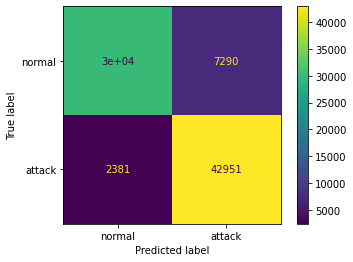

In [41]:
model_dt_u = DecisionTreeClassifier()

start = time.time()
model_dt_u.fit(model_rb_train_x, model_rb_train_y)
end = time.time()
print('Training time: ' + str(round(end-start, 2)) + ' sec')

model_rb_y_pred = model_dt_u.predict(model_rb_test_x)

print(accuracy_score(model_rb_test_y, model_rb_y_pred))

#Classification report
print(classification_report(model_rb_test_y, model_rb_y_pred, target_names = ['normal','attack']))

#confusion matrix
ConfusionMatrixDisplay.from_predictions(model_rb_test_y, model_rb_y_pred, display_labels = ['normal','attack'])
plt.show()

# Naive Bayes (Gaussian) after Rebalancing

Training time: 0.63 sec
0.5558470582519555
              precision    recall  f1-score   support

      normal       0.50      1.00      0.67     37000
      attack       1.00      0.19      0.32     45332

    accuracy                           0.56     82332
   macro avg       0.75      0.60      0.50     82332
weighted avg       0.78      0.56      0.48     82332



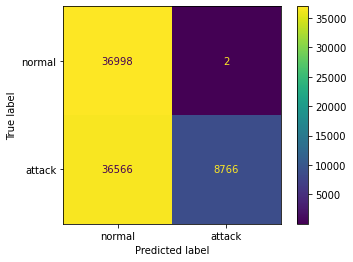

In [42]:
model_nbg_u = GaussianNB()

start = time.time()
model_nbg_u.fit(model_rb_train_x, model_rb_train_y)
end = time.time()
print('Training time: ' + str(round(end-start, 2)) + ' sec')

model_rb_y_pred = model_nbg_u.predict(model_rb_test_x)

print(accuracy_score(model_rb_test_y, model_rb_y_pred))

#Classification report
print(classification_report(model_rb_test_y, model_rb_y_pred, target_names = ['normal','attack']))

#confusion matrix
ConfusionMatrixDisplay.from_predictions(model_rb_test_y, model_rb_y_pred, display_labels = ['normal','attack'])
plt.show()

# Naive Bayes (Complement) after Rebalancing

Training time: 0.08 sec
0.6992542389350435
              precision    recall  f1-score   support

      normal       0.65      0.74      0.69     37000
      attack       0.76      0.67      0.71     45332

    accuracy                           0.70     82332
   macro avg       0.70      0.70      0.70     82332
weighted avg       0.71      0.70      0.70     82332



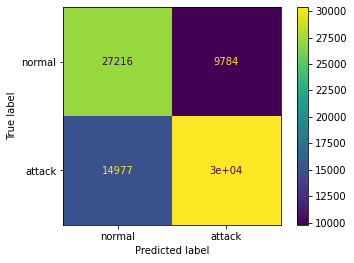

In [43]:
from sklearn.naive_bayes import ComplementNB
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

model_train_x_new = scaler.fit_transform(model_rb_train_x)
model_test_x_new = scaler.transform(model_rb_test_x)


model_nbc_u = ComplementNB()

start = time.time()
model_nbc_u.fit(model_train_x_new, model_rb_train_y)
end = time.time()
print('Training time: ' + str(round(end-start, 2)) + ' sec')

model_rb_y_pred = model_nbc_u.predict(model_test_x_new)

print(accuracy_score(model_rb_test_y, model_rb_y_pred))

#Classification report
print(classification_report(model_rb_test_y, model_rb_y_pred, target_names = ['normal','attack']))

#confusion matrix
ConfusionMatrixDisplay.from_predictions(model_rb_test_y, model_rb_y_pred, display_labels = ['normal','attack'])
plt.show()

# Random Forest after Rebalancing

Training time: 16.8 sec
0.9109823640868678
              precision    recall  f1-score   support

      normal       0.95      0.84      0.89     37000
      attack       0.88      0.97      0.92     45332

    accuracy                           0.91     82332
   macro avg       0.92      0.90      0.91     82332
weighted avg       0.91      0.91      0.91     82332



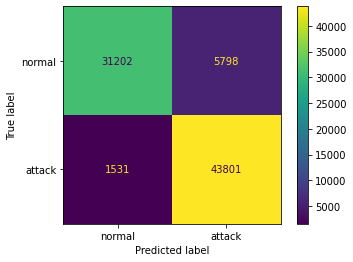

In [44]:
model_rf_u = RandomForestClassifier(max_depth=20, random_state=0)

start = time.time()
model_rf_u.fit(model_rb_train_x, model_rb_train_y)
end = time.time()
print('Training time: ' + str(round(end-start, 2)) + ' sec')

model_rb_y_pred = model_rf_u.predict(model_rb_test_x)

print(accuracy_score(model_rb_test_y, model_rb_y_pred))

#Classification report
print(classification_report(model_rb_test_y, model_rb_y_pred, target_names = ['normal','attack']))

#confusion matrix
ConfusionMatrixDisplay.from_predictions(model_rb_test_y, model_rb_y_pred, display_labels = ['normal','attack'])
plt.show()

# Neural Network after Rebalancing

Training time: 99.65 sec
0.891463829373755
              precision    recall  f1-score   support

      normal       0.93      0.82      0.87     37000
      attack       0.87      0.95      0.91     45332

    accuracy                           0.89     82332
   macro avg       0.90      0.88      0.89     82332
weighted avg       0.89      0.89      0.89     82332



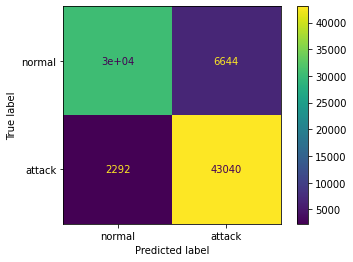

In [45]:
model_nn_u = MLPClassifier(solver='adam', max_iter=1000, hidden_layer_sizes = (10,5))

start = time.time()
model_nn_u.fit(model_rb_train_x, model_rb_train_y)
end = time.time()
print('Training time: ' + str(round(end-start, 2)) + ' sec')

model_rb_y_pred = model_nn_u.predict(model_rb_test_x)

print(accuracy_score(model_rb_test_y, model_rb_y_pred))

#Classification report
print(classification_report(model_rb_test_y, model_rb_y_pred, target_names = ['normal','attack']))

#confusion matrix
ConfusionMatrixDisplay.from_predictions(model_rb_test_y, model_rb_y_pred, display_labels = ['normal','attack'])
plt.show()

## Oversampling

<AxesSubplot:title={'center':'Count (target)'}>

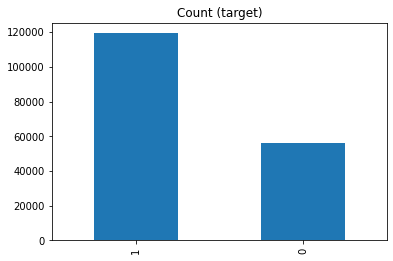

In [46]:
rb_train_x['label'].value_counts().plot(kind='bar', title='Count (target)')

In [47]:
#Creating synthetic samples of the minority class in a random way with replacement instead of creating exact copies 

rb_train_y = rb_train_x['label']
rb_train_x = rb_train_x.drop(['attack_cat','label'], axis=1)

test_y_over = rb_test_x['label']
test_x_over = rb_test_x.drop(['attack_cat','label'], axis=1)

ros = RandomOverSampler()
train_x_over, train_y_over = ros.fit_resample(rb_train_x, rb_train_y)

print(train_x_over.shape[0] - rb_train_x.shape[0], 'new random picked points')

63341 new random picked points


<AxesSubplot:title={'center':'Count (target)'}>

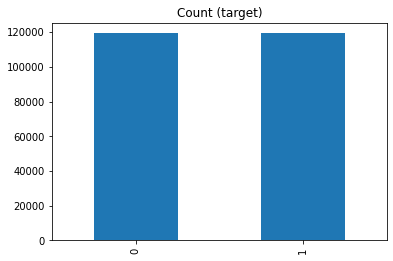

In [48]:
train_y_over.value_counts().plot(kind='bar', title='Count (target)')

# Logistic regression after Rebalancing

Training time: 72.16 sec
0.8352523927512996
              precision    recall  f1-score   support

      normal       0.90      0.72      0.80     37000
      attack       0.80      0.93      0.86     45332

    accuracy                           0.84     82332
   macro avg       0.85      0.82      0.83     82332
weighted avg       0.84      0.84      0.83     82332



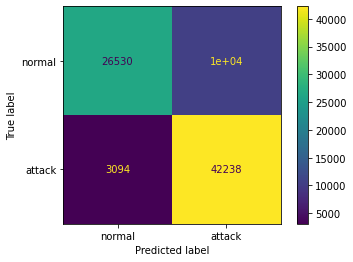

In [49]:
model_lr_o = LogisticRegression(max_iter=1000)

start = time.time()
model_lr_o.fit(train_x_over, train_y_over)
end = time.time()
print('Training time: ' + str(round(end-start, 2)) + ' sec')

y_pred_over = model_lr_o.predict(test_x_over)

print(accuracy_score(test_y_over, y_pred_over))

#Classification report
print(classification_report(test_y_over, y_pred_over, target_names = ['normal','attack']))

#confusion matrix
ConfusionMatrixDisplay.from_predictions(test_y_over, y_pred_over, display_labels = ['normal','attack'])
plt.show()

# Decision Tree after Rebalancing

Training time: 5.14 sec
0.8627508137783608
              precision    recall  f1-score   support

      normal       0.94      0.74      0.83     37000
      attack       0.82      0.96      0.89     45332

    accuracy                           0.86     82332
   macro avg       0.88      0.85      0.86     82332
weighted avg       0.87      0.86      0.86     82332



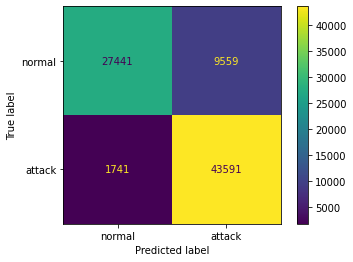

In [50]:
model_dt_o = DecisionTreeClassifier()

start = time.time()
model_dt_o.fit(train_x_over, train_y_over)
end = time.time()
print('Training time: ' + str(round(end-start, 2)) + ' sec')
y_pred_over = model_dt_o.predict(test_x_over)

print(accuracy_score(test_y_over, y_pred_over))

#Classification report
print(classification_report(test_y_over, y_pred_over, target_names = ['normal','attack']))

#confusion matrix
ConfusionMatrixDisplay.from_predictions(test_y_over, y_pred_over, display_labels = ['normal','attack'])
plt.show()

# Naive Bayes (Gaussian) after Rebalancing

Training time: 1.64 sec
0.5558470582519555
              precision    recall  f1-score   support

      normal       0.50      1.00      0.67     37000
      attack       1.00      0.19      0.32     45332

    accuracy                           0.56     82332
   macro avg       0.75      0.60      0.50     82332
weighted avg       0.78      0.56      0.48     82332



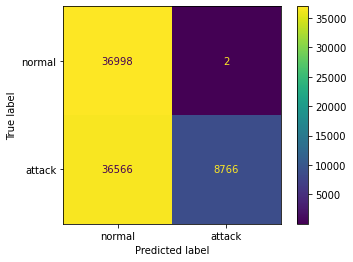

In [51]:
model_nbg_o = GaussianNB()

start = time.time()
model_nbg_o.fit(train_x_over, train_y_over)
end = time.time()
print('Training time: ' + str(round(end-start, 2)) + ' sec')

y_pred_over = model_nbg_o.predict(test_x_over)

print(accuracy_score(test_y_over, y_pred_over))

#Classification report
print(classification_report(test_y_over, y_pred_over, target_names = ['normal','attack']))

#confusion matrix
ConfusionMatrixDisplay.from_predictions(test_y_over, y_pred_over, display_labels = ['normal','attack'])
plt.show()

# Naive Bayes (Complement) after Rebalancing

Training time: 0.17 sec
0.6992542389350435
              precision    recall  f1-score   support

      normal       0.64      0.74      0.69     37000
      attack       0.76      0.67      0.71     45332

    accuracy                           0.70     82332
   macro avg       0.70      0.70      0.70     82332
weighted avg       0.71      0.70      0.70     82332



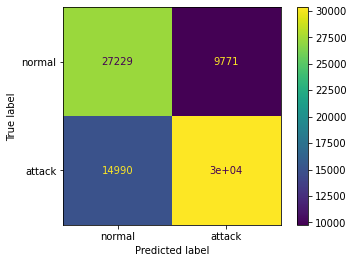

In [52]:
from sklearn.naive_bayes import ComplementNB
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

train_x_over_new = scaler.fit_transform(train_x_over)
test_x_over_new = scaler.transform(test_x_over)


model_nbc_o = ComplementNB()

start = time.time()
model_nbc_o.fit(train_x_over_new, train_y_over)
end = time.time()
print('Training time: ' + str(round(end-start, 2)) + ' sec')

y_pred_over = model_nbc_o.predict(test_x_over_new)

print(accuracy_score(test_y_over, y_pred_over))

#Classification report
print(classification_report(test_y_over, y_pred_over, target_names = ['normal','attack']))

#confusion matrix
ConfusionMatrixDisplay.from_predictions(test_y_over, y_pred_over, display_labels = ['normal','attack'])
plt.show()

# Neural Network after Rebalancing

Training time: 261.16 sec
0.90026963999417
              precision    recall  f1-score   support

      normal       0.95      0.82      0.88     37000
      attack       0.87      0.96      0.91     45332

    accuracy                           0.90     82332
   macro avg       0.91      0.89      0.90     82332
weighted avg       0.91      0.90      0.90     82332



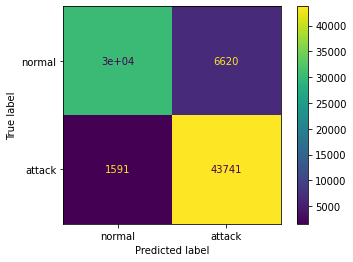

In [53]:
model_nn_o = MLPClassifier(solver='adam', max_iter=1000, hidden_layer_sizes = (10,5))

start = time.time()
model_nn_o.fit(train_x_over, train_y_over)
end = time.time()
print('Training time: ' + str(round(end-start, 2)) + ' sec')

y_pred_over = model_nn_o.predict(test_x_over)

print(accuracy_score(test_y_over, y_pred_over))

#Classification report
print(classification_report(test_y_over, y_pred_over, target_names = ['normal','attack']))

#confusion matrix
ConfusionMatrixDisplay.from_predictions(test_y_over, y_pred_over, display_labels = ['normal','attack'])
plt.show()

# Random Forest after Rebalancing

Training time: 38.74 sec
0.9045328669290191
              precision    recall  f1-score   support

      normal       0.96      0.82      0.89     37000
      attack       0.87      0.97      0.92     45332

    accuracy                           0.90     82332
   macro avg       0.91      0.90      0.90     82332
weighted avg       0.91      0.90      0.90     82332



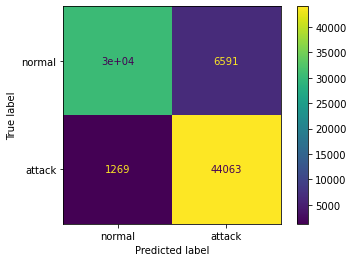

In [54]:
model_rf_o = RandomForestClassifier(max_depth=20, random_state=0)

start = time.time()
model_rf_o.fit(train_x_over, train_y_over)
end = time.time()
print('Training time: ' + str(round(end-start, 2)) + ' sec')

y_pred_over = model_rf_o.predict(test_x_over)

print(accuracy_score(test_y_over, y_pred_over))

#Classification report
print(classification_report(test_y_over, y_pred_over, target_names = ['normal','attack']))

#confusion matrix
ConfusionMatrixDisplay.from_predictions(test_y_over, y_pred_over, display_labels = ['normal','attack'])
plt.show()

# K-Fold Cross Validation (Unbalanced Dataset)

In [55]:
def print_metrics_u(results):
    metrics = ['sensitivity', 'specificity','precision_attack']
    for metric in metrics:
        print(f'{metric:15}', np.round(results["test_"+metric].mean(),3), [np.round(elem,3) for elem in results["test_"+metric]])
        if metric == 'sensitivity':
            sens_array = [np.round(elem,3) for elem in results["test_"+metric]]
        if metric == 'specificity':
            spec_array = [np.round(elem,3) for elem in results["test_"+metric]]
        if metric == 'precision_attack':
            prec_array = [np.round(elem,3) for elem in results["test_"+metric]]
    print()
    
    print(f'{"fit_time":15}', np.round(results["fit_time"].mean()))
    
    return sens_array, spec_array, prec_array

In [56]:
#K-fold cross validation on unbalanced dataset 

k_validation_data = k_validation_data.drop(['attack_cat'], axis=1)
k_validation_data_to_fit = k_validation_data.drop(['label'], axis=1)
model_array = [DecisionTreeClassifier(),
               LogisticRegression(max_iter = 1000), 
               RandomForestClassifier(max_depth=20, random_state=0), 
               MLPClassifier(solver='adam', max_iter=1000, hidden_layer_sizes = (10,5)),
               GaussianNB()
              ]

name_array = ['[[ Decision Tree ]]', '[[ Logistic Regression ]]', '[[ Random Forest]]', '[[ Neural Network ]]', '[[ Naive Bayes Gaussian ]]']
models_sensitivity_arrays = [[],[],[],[],[]]
models_specificity_arrays = [[],[],[],[],[]]
models_precision_arrays = [[],[],[],[],[]]

i = 0
j = 0

for model_ in model_array:
    print(name_array[i])
    metrics = cross_validate(model_, k_validation_data_to_fit, k_validation_data.label, 
                                cv = 10, 
                                scoring = {'precision_attack': make_scorer(precision_score,pos_label = 1),
                                            'sensitivity': make_scorer(recall_score,pos_label = 1), #sensitivity
                                            'specificity': make_scorer(recall_score,pos_label = 0) #specificity
                                          },
                                return_estimator = True
                                )
    model_sens_arr, model_spec_arr, model_prec_arr = print_metrics_u(metrics)
    models_sensitivity_arrays[j] = model_sens_arr
    models_specificity_arrays[j] = model_spec_arr
    models_precision_arrays[j] = model_prec_arr
    
    print()
    print()
    i = i+1
    j = j+1


[[ Decision Tree ]]
sensitivity     0.936 [0.845, 0.897, 0.896, 0.92, 0.967, 0.973, 0.968, 0.961, 0.977, 0.956]
specificity     0.864 [0.978, 0.99, 0.99, 0.991, 0.77, 0.719, 0.996, 0.974, 0.607, 0.632]
precision_attack 0.933 [0.985, 0.994, 0.993, 0.994, 0.881, 0.86, 0.997, 0.985, 0.815, 0.821]

fit_time        6.0


[[ Logistic Regression ]]
sensitivity     0.959 [0.906, 0.928, 0.935, 0.953, 0.986, 0.991, 0.986, 0.972, 0.985, 0.944]
specificity     0.766 [0.984, 0.988, 0.995, 0.99, 0.595, 0.525, 0.988, 0.943, 0.312, 0.336]
precision_attack 0.897 [0.99, 0.993, 0.997, 0.994, 0.812, 0.787, 0.993, 0.968, 0.717, 0.716]

fit_time        72.0


[[ Random Forest]]
sensitivity     0.944 [0.841, 0.902, 0.903, 0.923, 0.971, 0.98, 0.972, 0.969, 0.992, 0.985]
specificity     0.88 [0.98, 0.992, 0.993, 0.997, 0.807, 0.761, 0.995, 0.977, 0.624, 0.675]
precision_attack 0.94 [0.987, 0.995, 0.996, 0.998, 0.899, 0.879, 0.997, 0.987, 0.824, 0.843]

fit_time        41.0


[[ Neural Network ]]
sensitivity   

In [57]:
#sensitivity
lr_sens_array = models_sensitivity_arrays[1]
rf_sens_array = models_sensitivity_arrays[2]

#specificity
nn_spec_array = models_specificity_arrays[3]
nb_spec_array = models_specificity_arrays[4]

#precision
nn_prec_array = models_precision_arrays[3]
nb_prec_array = models_precision_arrays[4]


### T-test based on sensitivity metric 

In [58]:
#T-test between the two best classifier (based on sensitivity): Logistic Regression vs Random Forest

from statistics import mean
stat, p_val = ttest_ind(lr_sens_array, rf_sens_array)
alpha = 0.05
if p_val <= alpha: #we can reject the NullHypothesis (null hypothesys: distribution are statistically the same)
    print("We reject the null hypothesis at a confidence level of 5%")
    lr_sens_mean = mean(lr_sens_array)
    rf_sens_mean = mean(rf_sens_array)
    if(lr_sens_mean > rf_sens_mean):
        best = 'Logistic Regression'
    else:
        best = 'Random Forest'
        
    print("Distributions are statistically different in terms of sensitivity [p: " + str(p_val) + "]. The best classifier is "+ best)
    
else:
    print("Cannot reject the null hypothesis")
    print("Distributions are not statistically different [ p: " + str(p_val) + " ]")
    


Cannot reject the null hypothesis
Distributions are not statistically different [ p: 0.42699881823363584 ]


### T-test based on specificity metric 

In [59]:
#T-test between the two best classifier (based on specificity): Naive Bayes & Neural Network

from statistics import mean
stat, p_val = ttest_ind(nn_spec_array, nb_spec_array)
alpha = 0.05
if p_val <= alpha: #we can reject the NullHypothesis (null hypothesis: distribution a statistically the same)
    print("We reject the null hypothesis at a confidence level of 5%")
    
    nn_spec_mean = mean(nn_spec_array)
    nb_spec_mean = mean(nb_spec_array)
    if(nn_spec_mean > nb_spec_mean):
        best = 'Neural Network'
    else:
        best = 'Naive Bayes'
        
    print("Distributions are statistically different in terms of specificity [ p: " + str(p_val) + " ]. The best classifier is "+ best)
    
else:
    print("Cannot reject the null hypothesis")
    print("Distributions are not statistically different [ p: " + str(p_val) + " ]")


We reject the null hypothesis at a confidence level of 5%
Distributions are statistically different in terms of specificity [ p: 0.023364002981370858 ]. The best classifier is Naive Bayes


### T-test based on precision metric 

In [60]:
#T-test between the two best classifier (based on precision): Naive Bayes & Neural Network

from statistics import mean
stat, p_val = ttest_ind(nn_prec_array, nb_prec_array)
alpha = 0.05
if p_val <= alpha: #we can reject the NullHypothesis (null hypothesis: distribution a statistically the same)
    print("We reject the null hypothesis at a confidence level of 5%")
    
    nn_prec_mean = mean(nn_prec_array)
    nb_prec_mean = mean(nb_prec_array)
    if(nn_prec_mean > nb_prec_mean):
        best = 'Neural Network'
    else:
        best = 'Naive Bayes'
        
    print("Distributions are statistically different in terms of precision [ p: " + str(p_val) + " ]. The best classifier is "+ best)
    
else:
    print("Cannot reject the null hypothesis")
    print("Distributions are not statistically different [ p: " + str(p_val) + " ]")

We reject the null hypothesis at a confidence level of 5%
Distributions are statistically different in terms of precision [ p: 0.02119997712293114 ]. The best classifier is Naive Bayes


# K-Fold Cross Validation (Rebalanced Dataset - Undersampling)

In [61]:
def print_metrics_rb(results):
    metrics = ['sensitivity', 'specificity','precision_attack', 'accuracy']
    for metric in metrics:
        print(f'{metric:15}', np.round(results["test_"+metric].mean(),3), [np.round(elem,3) for elem in results["test_"+metric]])
        if metric == 'accuracy':
            acc_array = [np.round(elem,3) for elem in results["test_"+metric]]
    print()
    
    print(f'{"fit_time":15}', np.round(results["fit_time"].mean()))
    
    return acc_array

In [62]:
#K-fold cross validation on rebalanced dataset (undersampling)

# Pipeline to use rebalanced dataset in cross validation
pipe_dt_u = Pipeline([('sampling', RandomUnderSampler()),('classification', DecisionTreeClassifier())])
pipe_lr_u = Pipeline([('sampling', RandomUnderSampler()),('classification', LogisticRegression(max_iter=1000))])
pipe_rf_u = Pipeline([('sampling', RandomUnderSampler()),('classification', RandomForestClassifier(max_depth=20, random_state=0))])
pipe_nn_u = Pipeline([('sampling', RandomUnderSampler()),('classification', MLPClassifier(solver='adam', max_iter=1000, hidden_layer_sizes = (10,5)))])
pipe_nb_u = Pipeline([('sampling', RandomUnderSampler()),('classification', GaussianNB())])


pipe_array_u = [pipe_dt_u,
                pipe_lr_u,
                pipe_rf_u,
                pipe_nn_u,
                pipe_nb_u
               ]

name_array = ['[[ Decision Tree ]]', '[[ Logistic Regression ]]', '[[ Random Forest]]', '[[ Neural Network ]]', '[[ Naive Bayes Gaussian ]]']
models_accuracy_arrays = [[],[],[],[],[]]

i = 0
j = 0

for pipe_ in pipe_array_u:
    print(name_array[i])
    metrics = cross_validate(pipe_, k_validation_data_to_fit, k_validation_data.label, 
                                cv = 10, 
                                scoring = {'precision_attack': make_scorer(precision_score,pos_label = 1),
                                            'sensitivity': make_scorer(recall_score,pos_label = 1), #sensitivity
                                            'specificity': make_scorer(recall_score,pos_label = 0), #specificity
                                            'accuracy': make_scorer(accuracy_score)
                                          },
                                return_estimator = True
                                )
    model_acc_array = print_metrics_rb(metrics)
    models_accuracy_arrays[j] = model_acc_array
    
    print()
    print()
    i = i+1
    j = j+1

[[ Decision Tree ]]
sensitivity     0.92 [0.82, 0.873, 0.862, 0.901, 0.956, 0.967, 0.963, 0.952, 0.968, 0.939]
specificity     0.891 [0.987, 0.993, 0.993, 0.995, 0.809, 0.773, 0.996, 0.982, 0.681, 0.705]
precision_attack 0.944 [0.991, 0.995, 0.995, 0.997, 0.899, 0.883, 0.997, 0.989, 0.843, 0.849]
accuracy        0.91 [0.88, 0.916, 0.909, 0.935, 0.903, 0.897, 0.975, 0.962, 0.865, 0.854]

fit_time        6.0


[[ Logistic Regression ]]
sensitivity     0.903 [0.791, 0.84, 0.837, 0.88, 0.96, 0.972, 0.963, 0.934, 0.954, 0.9]
specificity     0.855 [0.986, 0.996, 0.998, 0.997, 0.75, 0.727, 0.993, 0.967, 0.528, 0.603]
precision_attack 0.928 [0.99, 0.997, 0.999, 0.998, 0.872, 0.863, 0.996, 0.981, 0.781, 0.8]
accuracy        0.886 [0.862, 0.896, 0.895, 0.922, 0.884, 0.883, 0.974, 0.946, 0.8, 0.793]

fit_time        44.0


[[ Random Forest]]
sensitivity     0.918 [0.801, 0.863, 0.858, 0.891, 0.952, 0.967, 0.958, 0.955, 0.975, 0.956]
specificity     0.933 [0.982, 0.995, 0.998, 0.999, 0.893, 0.88, 

## T-Test based on two best classifier (based on accuracy metric) [Undersampling]

In [63]:
#Neural Network vs Random Forest

rf_acc_array = models_accuracy_arrays[2]
print(rf_acc_array)
nn_acc_array = models_accuracy_arrays[3]
print(nn_acc_array)

from statistics import mean
stat, p_val = ttest_ind(nn_acc_array, rf_acc_array)
alpha = 0.05
if p_val <= alpha: #we can reject the NullHypothesis (null hypothesis: distribution a statistically the same)
    print("We reject the null hypothesis at a confidence level of 5%")
    
    nn_acc_mean = mean(nn_acc_array)
    rf_acc_mean = mean(rf_acc_array)
    if(nn_acc_mean > rf_acc_mean):
        best = 'Neural Network'
    else:
        best = 'Random Forest'
        
    print("Distributions are statistically different in terms of accuracy [ p: " + str(p_val) + " ]. The best classifier is "+ best)
    
else:
    print("Cannot reject null hypothesis")
    print("Distributions are not statistically different [ p: " + str(p_val) + " ]")

[0.866, 0.911, 0.908, 0.93, 0.931, 0.935, 0.972, 0.967, 0.904, 0.905]
[0.86, 0.903, 0.9, 0.93, 0.921, 0.933, 0.968, 0.957, 0.914, 0.91]
Cannot reject null hypothesis
Distributions are not statistically different [ p: 0.8143614329911644 ]


# K-Fold Cross Validation (Rebalanced dataset Oversampling) 

In [64]:
##K-fold cross validation on rebalanced dataset (oversampling)

# Pipeline to use rebalanced dataset in cross validation
pipe_dt_o = Pipeline([('sampling', RandomOverSampler()),('classification', DecisionTreeClassifier())])
pipe_lr_o = Pipeline([('sampling', RandomOverSampler()),('classification', LogisticRegression(max_iter=1000))])
pipe_rf_o = Pipeline([('sampling', RandomOverSampler()),('classification', RandomForestClassifier(max_depth=20, random_state=0))])
pipe_nn_o = Pipeline([('sampling', RandomOverSampler()),('classification', MLPClassifier(solver='adam', max_iter=1000, hidden_layer_sizes = (10,5)))])
pipe_nb_o = Pipeline([('sampling', RandomOverSampler()),('classification', GaussianNB())])


pipe_array_o = [pipe_dt_o,
                pipe_lr_o,
                pipe_rf_o,
                pipe_nn_o
                pipe_nb_o
               ]

name_array = ['[[ Decision Tree ]]', '[[ Logistic Regression ]]', '[[ Random Forest]]', '[[ Neural Network ]]', '[[ Naive Bayes Gaussian ]]']
models_accuracy_arrays = [[],[],[],[],[]]

i = 0
j = 0

for pipe_ in pipe_array_o:
    print(name_array[i])
    metrics = cross_validate(pipe_, k_validation_data_to_fit, k_validation_data.label, 
                                cv = 10, 
                                scoring = {'precision_attack': make_scorer(precision_score,pos_label = 1),
                                            'sensitivity': make_scorer(recall_score,pos_label = 1), #sensitivity
                                            'specificity': make_scorer(recall_score,pos_label = 0), #specificity
                                            'accuracy': make_scorer(accuracy_score)
                                          },
                                return_estimator = True
                                )
    model_acc_array = print_metrics_rb(metrics)
    models_accuracy_arrays[j] = model_acc_array
    
    print()
    print()
    i = i+1
    j = j+1

[[ Decision Tree ]]
sensitivity     0.937 [0.852, 0.898, 0.893, 0.919, 0.966, 0.973, 0.97, 0.962, 0.978, 0.957]
specificity     0.865 [0.979, 0.99, 0.984, 0.991, 0.763, 0.726, 0.995, 0.974, 0.608, 0.635]
precision_attack 0.933 [0.986, 0.994, 0.99, 0.995, 0.878, 0.863, 0.997, 0.985, 0.815, 0.823]
accuracy        0.911 [0.898, 0.931, 0.926, 0.945, 0.893, 0.884, 0.979, 0.966, 0.845, 0.841]

fit_time        11.0


[[ Logistic Regression ]]
sensitivity     0.903 [0.792, 0.841, 0.838, 0.881, 0.96, 0.972, 0.963, 0.933, 0.952, 0.897]
specificity     0.856 [0.99, 0.996, 0.998, 0.997, 0.755, 0.732, 0.993, 0.967, 0.53, 0.605]
precision_attack 0.929 [0.993, 0.998, 0.999, 0.998, 0.874, 0.865, 0.996, 0.981, 0.782, 0.801]
accuracy        0.886 [0.864, 0.897, 0.896, 0.923, 0.886, 0.885, 0.974, 0.946, 0.8, 0.792]

fit_time        119.0


[[ Random Forest]]
sensitivity     0.923 [0.81, 0.871, 0.865, 0.901, 0.956, 0.968, 0.961, 0.958, 0.98, 0.965]
specificity     0.923 [0.981, 0.994, 0.997, 0.999, 0.88, 

## T-Test based on two best classifier (based on accuracy metric) [Oversampling]

In [65]:
#Decision Tree vs Random Forest

rf_acc_array = models_accuracy_arrays[2]
print(rf_acc_array)
dt_acc_array = models_accuracy_arrays[0]
print(dt_acc_array)

from statistics import mean
stat, p_val = ttest_ind(dt_acc_array, rf_acc_array)
alpha = 0.05
if p_val <= alpha: #we can reject the NullHypothesis (null hypothesis: distribution a statistically the same)
    print("We reject the null hypothesis at a confidence level of 5%")
    
    dt_acc_mean = mean(dt_acc_array)
    rf_acc_mean = mean(rf_acc_array)
    if(dt_acc_mean > rf_acc_mean):
        best = 'Decision Tree'
    else:
        best = 'Random Forest'
        
    print("Distributions are statistically different in terms of accuracy[ p: " + str(p_val) + " ]. The best classifier is "+ best)
    
else:
    print("Cannot reject null hypothesis")
    print("Distributions are not statistically different [ p: " + str(p_val) + " ]")

[0.872, 0.915, 0.913, 0.936, 0.928, 0.928, 0.974, 0.968, 0.896, 0.902]
[0.898, 0.931, 0.926, 0.945, 0.893, 0.884, 0.979, 0.966, 0.845, 0.841]
Cannot reject null hypothesis
Distributions are not statistically different [ p: 0.496209870842114 ]
